In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, uniform
import pandas as pd
import time
import tinyDA as tda

import uuid

## 1. ML Settings

In [2]:
n_levels = 3
coarsening = 2
n_params = 5

## 2. Load Input Data

In [3]:
# load P, PET, Q data
df = pd.read_csv("./hourly_data/02472000_hourly_nldas_LeafRiver.csv", parse_dates=[0], usecols=[0, 4, 8, 9], index_col=0)
df_flow = pd.read_csv("./hourly_data/02472000-usgs-hourly_LeafRiver.csv", parse_dates=[0], usecols=[0, 1, 6], index_col=0)

et_data = df.iloc[:, 0]
et_data = np.where(et_data < 0, 0., et_data)

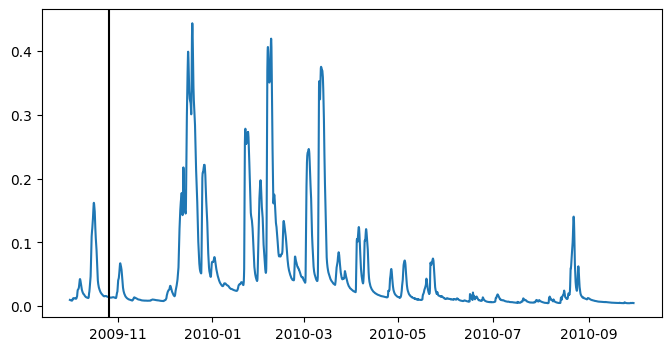

In [4]:
start_, end_ = "2009-10-01", "2010-09-30"

# make series and handle units
p_series = pd.Series(data=df.iloc[:, 2], index=pd.DatetimeIndex(df.index)).truncate(before=start_, after=end_).interpolate() # mm/d

et_series = pd.Series(data=et_data, index=pd.DatetimeIndex(df.index)).truncate(before=start_, after=end_).interpolate() # mm/d

qout_series = pd.Series(data=df_flow.iloc[:, 0], index=pd.DatetimeIndex(df.index)).truncate(before=start_, after=end_).interpolate() # mm/d

warmup = 24 * 25
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(qout_series)
ax.axvline(qout_series.index[warmup], c="black")

## 2. Define Model

In [5]:
def hymod_euler(Precip, PET, smax, beta, alpha, k_slow, k_quick, step=1):
    # initialize states
    s_upper_zone = 1.
    s_slow = 1.
    s_quick = [1., 1., 1.]
    
    # initialize global outflow data structure
    outflow = []
    # initialize state data structure
    states = []
    # get number of time steps
    tmax = len(Precip)
    
    # ensure that step is an integer
    step = int(step)
    # initialize time step
    t = 0
    
    while t < tmax:
        # compute precipitation excess from upper zone
        s_upper_zone, outflow_upper_zone = upper_reservoir_euler(
            state = s_upper_zone,
            inflow = Precip[t],
            pet = PET[t],
            beta = beta,
            smax = smax,
            step = step
        )
        
        # split outflow from upper zone
        inflow_slow = (1 - alpha) * outflow_upper_zone
        inflow_quick = alpha * outflow_upper_zone
        
        # compute slow reservoir contribution to global outflow
        s_slow, outflow_slow = linear_reservoir_euler(
            state = s_slow,
            inflow = inflow_slow,
            k = k_slow,
            step = step
        )
        
        # update global outflow
        global_outflow = outflow_slow
        
        # compute contribution of quick reservoir series to global outflow
        for n in range(3):
            s_quick[n], inflow_quick = linear_reservoir_euler(
                state = s_quick[n],
                inflow = inflow_quick,
                k = k_quick,
                step = step
            )
            
        # update global outflow
        global_outflow += inflow_quick
            
        # save global outflow
        outflow.append(global_outflow)
        
        # increment time step index
        t += step
    
    return outflow

def linear_reservoir_euler(state, inflow, k, step):
    """
    Computes state y_(n+1) from state y_(n) using the Euler method
    for a linear reservoir with inflow and storage coefficient k.
    
    Parameters
    ----------
    :param state: the current state y_(n); float
    :param inflow: the inflow flux [L/T] at time step (n); float
    :param k: storage coefficient [1/T]; float
    :param step: the step size of the Euler method; float
    
    Returns
    -------
    :return new_state: the new state y_(n+1); float
    :return outflow: the outflow from the reservoir; float
    """
    
    dSdt = inflow - k * state
    outflow = k * state
    new_state = state + step * dSdt
    
    if new_state < 0.:
        new_state = 0.
        
    if outflow < 0.:
        outflow = 0.
    
    return new_state, outflow

def upper_reservoir_euler(state, inflow, pet, beta, smax, step):
    """
    Computes state y_(n+1) from state y_(n) using the Euler method
    for the HYMOD upper reservoir with inflow, evaporation, maximum
    storage height, and distribution coefficient.
    
    see https://superflexpy.readthedocs.io/en/latest/popular_models.html#hymod
    for the governing equations
    
    Parameters
    ----------
    :param state: the current state y_(n); float
    :param inflow: the inflow flux [L/T] at time step (n); float
    :param pet: the potential evapotranspiration flux [L/T] at time
        step (n); float
    :param beta: the distribution coefficient; float
    :param smax: the maximum storage height [L]; float
    :param step: the step size of the Euler method; float
    
    Returns
    -------
    """
    
    s_bar = state / smax
    
    if state - pet > 0.:
        pet = pet
    else:
        pet = pet - state
    
    dSdt = inflow - pet - inflow * (1 - min(1, max(0, (1 - s_bar))) ** beta)
    
    outflow = inflow * (1 - min(1, max(0, (1 - s_bar))) ** beta)
    new_state = state + step * dSdt
    
    if new_state < 0.:
        new_state = 0.
        
    if outflow < 0.:
        outflow = 0.
    
    return new_state, outflow

## 3. Create some observations with the fine model

In [6]:
def my_model_level0(parameters):
    step = 4
    
    outflow = hymod_euler(
        Precip=p_series,
        PET=et_series,
        smax=parameters[0],
        beta=parameters[1],
        alpha=parameters[2],
        k_slow=parameters[3],
        k_quick=parameters[4],
        step=step
    )
    
    # resample solution to original frequency via linear interpolation
    outflow = pd.Series(outflow, index=p_series.index[::step]).reindex(p_series.index).interpolate().values
    
    warmup = 24 * 25
    return outflow[warmup:]

def my_model_level1(parameters):
    step = 2
    
    outflow = hymod_euler(
        Precip=p_series,
        PET=et_series,
        smax=parameters[0],
        beta=parameters[1],
        alpha=parameters[2],
        k_slow=parameters[3],
        k_quick=parameters[4],
        step=step
    )
    
    # resample solution to original frequency via linear interpolation
    outflow = pd.Series(outflow, index=p_series.index[::step]).reindex(p_series.index).interpolate().values
    
    warmup = 24 * 25
    return outflow[warmup:]

def my_model_level2(parameters):
    step = 1
    
    outflow = hymod_euler(
        Precip=p_series,
        PET=et_series,
        smax=parameters[0],
        beta=parameters[1],
        alpha=parameters[2],
        k_slow=parameters[3],
        k_quick=parameters[4],
        step=step
    )
    
    # resample solution to original frequency via linear interpolation
    outflow = pd.Series(outflow, index=p_series.index[::step]).reindex(p_series.index).interpolate().values
    
    warmup = 24 * 25
    return outflow[warmup:]

In [7]:
my_models = [my_model_level0, my_model_level1, my_model_level2]

### 3. Set up statistical model and draw prior samples

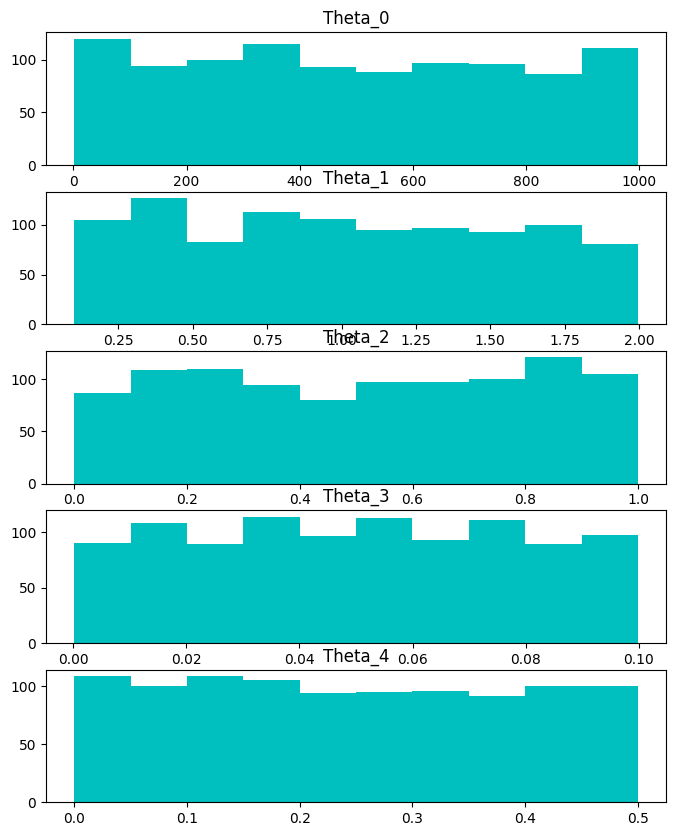

In [8]:
my_prior = tda.CompositePrior([
    uniform(loc=1., scale=999.),
    uniform(loc=.1, scale=1.9),
    uniform(loc=0.0, scale=1.),
    uniform(loc=0.0, scale=0.1),
    uniform(loc=0.0, scale=0.5)
])

# plot
prior_samples = my_prior.rvs(1000)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (8, 10))
for i in range(5):
    axes[i].set_title('Theta_{}'.format(i))
    axes[i].hist(prior_samples[:,i], color='c')

In [9]:
my_posteriors = []

for i in range(n_levels):
    warmup = 24 * 25
    cov_likelihood = 1. ** 2 * np.eye(len(qout_series[warmup:]))
    loglike = tda.GaussianLogLike(qout_series.values[warmup:], cov_likelihood) # can be AdaptiveGaussianLogLike
    posterior = tda.Posterior(my_prior, loglike, my_models[i])
    my_posteriors.append(posterior)

### 4. Set up the proposal

In [10]:
dream_m0 = 200
dream_delta = 1
dream_Z_method = 'lhs'
dream_adaptive = False
my_proposal = tda.SingleDreamZ(M0=dream_m0, delta=dream_delta, Z_method=dream_Z_method, adaptive=dream_adaptive)

# random walk Metropolis
# rwmh_cov = np.eye(n_params)
# rmwh_scaling = 0.1
# rwmh_adaptive = True
# my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# Adaptive Metropolis
# am_cov = np.eye(n_params)
# am_t0 = 100
# am_sd = None
# am_epsilon = 1e-6
# am_adaptive = True
# my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

# dream_m0 = 1000
# dream_delta = 1
# dream_Z_method = 'lhs'
# dream_adaptive = False
# my_proposal = tda.SingleDreamZ(M0=dream_m0, delta=dream_delta, Z_method=dream_Z_method,
#                                adaptive=dream_adaptive)

C:\Users\Rudolph\anaconda3\envs\tinyDA\lib\site-packages\tinyDA\proposal.py:779: UserWarning:  SingleDreamZ is an EXPERIMENTAL proposal, similar to the DREAM(ZS) algorithm (see e.g. Vrugt 2016), but using only a single chain.

  warnings.warn(


### 5. Sampling

In [13]:
start = time.time()

my_chain = tda.sample(my_posteriors, my_proposal, iterations=2000, n_chains=20, # MLDA
                      subsampling_rate=5, force_sequential=False)

print("time: {:1.2f}".format(time.time() - start))

Sampling 20 chains in parallel


2024-02-05 10:18:31,281	INFO worker.py:1538 -- Started a local Ray instance.
(RemoteMLDAChain pid=35280) C:\Users\Rudolph\AppData\Local\Temp\3\ipykernel_26220\3399142206.py:85: RuntimeWarning: overflow encountered in scalar add
(RemoteMLDAChain pid=2820) C:\Users\Rudolph\AppData\Local\Temp\3\ipykernel_26220\3399142206.py:85: RuntimeWarning: overflow encountered in scalar multiply
(RemoteMLDAChain pid=2820) C:\Users\Rudolph\AppData\Local\Temp\3\ipykernel_26220\3399142206.py:85: RuntimeWarning: overflow encountered in scalar add
(RemoteMLDAChain pid=21672) C:\Users\Rudolph\AppData\Local\Temp\3\ipykernel_26220\3399142206.py:85: RuntimeWarning: overflow encountered in scalar add
(RemoteMLDAChain pid=35280) C:\Users\Rudolph\AppData\Local\Temp\3\ipykernel_26220\3399142206.py:85: RuntimeWarning: overflow encountered in scalar multiply
(RemoteMLDAChain pid=2820) C:\Users\Rudolph\AppData\Local\Temp\3\ipykernel_26220\3399142206.py:125: RuntimeWarning: divide by zero encountered in scalar power
(

time: 6758.53


In [14]:
print(my_chain.keys())

dict_keys(['sampler', 'n_chains', 'iterations', 'levels', 'subsampling_rates', 'chain_l0_0', 'chain_l1_0', 'chain_l2_0', 'chain_l0_1', 'chain_l1_1', 'chain_l2_1', 'chain_l0_2', 'chain_l1_2', 'chain_l2_2', 'chain_l0_3', 'chain_l1_3', 'chain_l2_3', 'chain_l0_4', 'chain_l1_4', 'chain_l2_4', 'chain_l0_5', 'chain_l1_5', 'chain_l2_5', 'chain_l0_6', 'chain_l1_6', 'chain_l2_6', 'chain_l0_7', 'chain_l1_7', 'chain_l2_7', 'chain_l0_8', 'chain_l1_8', 'chain_l2_8', 'chain_l0_9', 'chain_l1_9', 'chain_l2_9', 'chain_l0_10', 'chain_l1_10', 'chain_l2_10', 'chain_l0_11', 'chain_l1_11', 'chain_l2_11', 'chain_l0_12', 'chain_l1_12', 'chain_l2_12', 'chain_l0_13', 'chain_l1_13', 'chain_l2_13', 'chain_l0_14', 'chain_l1_14', 'chain_l2_14', 'chain_l0_15', 'chain_l1_15', 'chain_l2_15', 'chain_l0_16', 'chain_l1_16', 'chain_l2_16', 'chain_l0_17', 'chain_l1_17', 'chain_l2_17', 'chain_l0_18', 'chain_l1_18', 'chain_l2_18', 'chain_l0_19', 'chain_l1_19', 'chain_l2_19'])


In [15]:
# print("len chains level0: {}, {}".format(len(my_chain["chain_l0_0"]), len(my_chain["chain_l0_1"])))
# print("len chains level1: {}, {}".format(len(my_chain["chain_l1_0"]), len(my_chain["chain_l1_1"])))
# print("len chains level2: {}, {}".format(len(my_chain["chain_l2_0"]), len(my_chain["chain_l2_1"])))

### 6. Diagnostics

In [16]:
idata = tda.to_inference_data(my_chain, level="2", burnin=0)

C:\Users\Rudolph\anaconda3\envs\tinyDA\lib\site-packages\arviz\data\inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [17]:
import arviz as az

In [18]:
az.summary(idata)

C:\Users\Rudolph\anaconda3\envs\tinyDA\lib\site-packages\arviz\utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,226.971,101.345,74.435,418.597,1.167,0.825,6847.0,7155.0,1.0
theta_1,1.356,0.445,0.566,2.000,0.004,0.003,10632.0,12880.0,1.0
theta_2,0.748,0.221,0.305,1.000,0.003,0.002,6243.0,4639.0,1.0
theta_3,0.035,0.027,0.000,0.087,0.000,0.000,10002.0,14346.0,1.0
theta_4,0.049,0.020,0.027,0.071,0.000,0.000,7297.0,4045.0,1.0


In [19]:
az.summary(idata).describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,5.000000,5.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.0
mean,45.831800,20.41160,15.066600,84.35100,0.234800,0.166000,8204.200000,8613.000000,1.0
std,101.261379,45.24348,33.188745,186.85088,0.521119,0.368394,1977.220701,4739.716289,0.0
min,0.035000,0.02000,0.000000,0.07100,0.000000,0.000000,6243.000000,4045.000000,1.0
25%,0.049000,0.02700,0.027000,0.08700,0.000000,0.000000,6847.000000,4639.000000,1.0
50%,0.748000,0.22100,0.305000,1.00000,0.003000,0.002000,7297.000000,7155.000000,1.0
75%,1.356000,0.44500,0.566000,2.00000,0.004000,0.003000,10002.000000,12880.000000,1.0
max,226.971000,101.34500,74.435000,418.59700,1.167000,0.825000,10632.000000,14346.000000,1.0


C:\Users\Rudolph\anaconda3\envs\tinyDA\lib\site-packages\arviz\utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


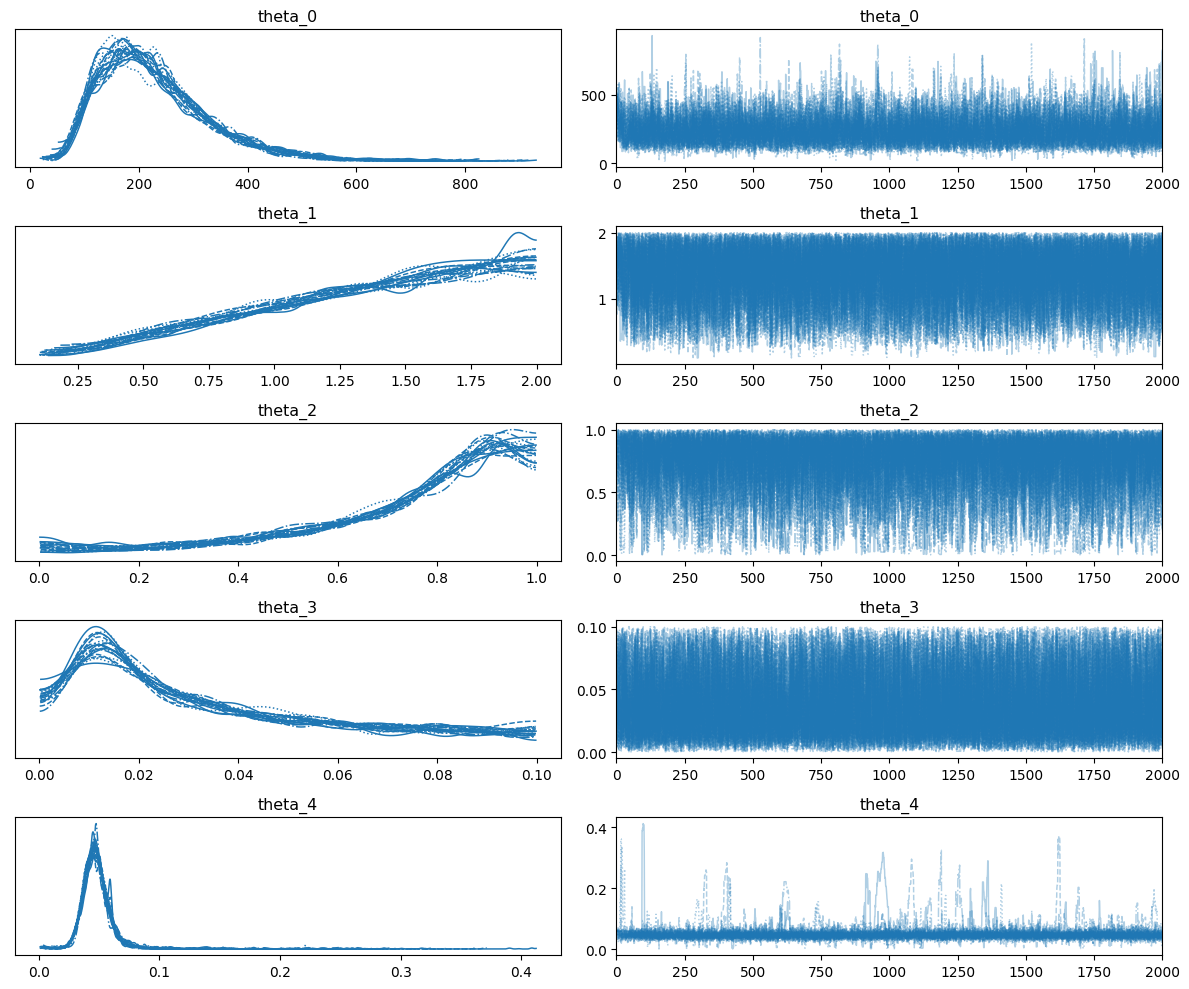

In [20]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [23]:
posterior_ = idata.posterior

posterior_thin = posterior_.isel(draw=slice(None, None, 5))

df = posterior_thin.to_dataframe().reset_index()

print(df.head())
print(df.shape)

   chain  draw     theta_0   theta_1   theta_2   theta_3   theta_4
0      0     0  485.558166  1.514418  0.911516  0.030213  0.059310
1      0     5  359.352531  1.933180  0.908835  0.025313  0.059309
2      0    10  587.951814  1.816242  0.921310  0.058433  0.059308
3      0    15  115.073389  0.358297  0.737234  0.028439  0.059315
4      0    20  115.073388  0.386566  0.801885  0.039010  0.059298
(8020, 7)


In [24]:
# get parameter samples

samples = df.iloc[:, 2:].to_numpy()

print(samples.shape)

# save samples
np.savetxt("EX01_HYMOD_MLDA_parameter_samples.csv", samples, delimiter=";")

(8020, 5)


In [25]:
simulations = idata.posterior_predictive

simulations_thin = simulations.isel(draw=slice(None, None, 5))

df = simulations_thin.to_dataframe().reset_index()

print(df.head())
print(df.shape)

   chain  draw     obs_0     obs_1     obs_2     obs_3     obs_4     obs_5  \
0      0     0  0.011608  0.011258  0.010914  0.010576  0.010244  0.009919   
1      0     5  0.015824  0.015351  0.014886  0.014429  0.013981  0.013541   
2      0    10  0.011244  0.010902  0.010565  0.010235  0.009911  0.009593   
3      0    15  0.011272  0.010935  0.010604  0.010280  0.009961  0.009649   
4      0    20  0.011757  0.011395  0.011040  0.010692  0.010351  0.010016   

      obs_6     obs_7  ...  obs_8127  obs_8128  obs_8129  obs_8130  obs_8131  \
0  0.009600  0.009288  ...  0.000030  0.000029  0.000028  0.000027  0.000026   
1  0.013110  0.012688  ...  0.000052  0.000050  0.000048  0.000047  0.000045   
2  0.009281  0.008977  ...  0.000029  0.000028  0.000027  0.000026  0.000025   
3  0.009344  0.009045  ...  0.000027  0.000026  0.000025  0.000025  0.000024   
4  0.009689  0.009369  ...  0.000029  0.000028  0.000027  0.000026  0.000025   

   obs_8132  obs_8133  obs_8134  obs_8135  obs_813

In [26]:
# get posterior simulations

simulations = df.iloc[:, 2:].to_numpy() # [rnd, :]
print(type(simulations))
print(simulations.shape)

lower_q = []
median = []
upper_q = []

for i in range(len(qout_series[warmup:])):
    lower_q.append(np.quantile(simulations[:, i], 0.01))
    median.append(np.quantile(simulations[:, i], 0.5))
    upper_q.append(np.quantile(simulations[:, i], 0.99))
    
uncertainties = np.vstack((lower_q, median, upper_q)).T
print(uncertainties.shape)
print(uncertainties[:5, :])

np.savetxt("EX01_HYMOD_MLDA_uncertainty_estimates.csv", uncertainties, delimiter=";")

<class 'numpy.ndarray'>
(8020, 8137)
(8137, 3)
[[0.00903553 0.01759299 0.02890677]
 [0.00881281 0.01728939 0.02864987]
 [0.0085806  0.01701463 0.02843312]
 [0.00832777 0.01672536 0.02821117]
 [0.00808204 0.01642413 0.02793973]]


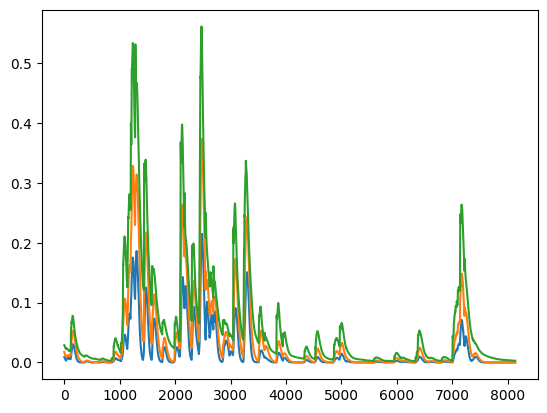

In [27]:
plt.plot(uncertainties)